<a href="https://colab.research.google.com/github/Beatriz-Yun/AIFFEL_LMS/blob/main/Exploration/%5BE-06%5DKaggle%EC%A7%91%EA%B0%92%EC%98%88%EC%B8%A1%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 학습 목표
- 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.
- 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.
- 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.
- 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.
- Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.

<br>

---

<br>

이번 노드에서는 **회귀 모델을 구현**하는 데에 사용하는 **xgboost**와 **lightgbm** 라이브러리와, **결측 데이터를 확인**하는 **missingno** 라이브러리가 필요합니다.<br><br>
**pip list | grep 라이브러리명** 명령어를 통해 설치 여부를 확인한다.

In [1]:
!pip list | grep xgboost
!pip list | grep lightgbm
!pip list | grep missingno
!pip list | grep scikit-learn

xgboost                       0.90
lightgbm                      2.2.3
missingno                     0.5.0
scikit-learn                  0.22.2.post1


실습을 진행할 Kaggle대회 링크<br>
--> [Kaggle 코리아와 함께하는 2nd ML 대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

<br>

캐글에는 아주 다양한 경진대회들이 있고, 각 경진대회들은 모두 대회 소개, 데이터셋 소개, 규칙 설명 등 대회에 참가하는 사람들을 위한 세부 내용들로 구성되어 있다.

이번 대회의 **평가기준은 RMSE**이다.
> RMSE는 Root Mean Squared Error 의 약자이며, 수식은 다음과 같다. $${\sqrt{ {1 \over N} \sum{(y_t - y_{pr})}^2}} $$
이는 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근이다.

이번 대회에서 다루는 문제는 **"집값"을 예측하는 문제(회귀문제)**이기 때문에 우리가 예측해야 하는 값과 실제 정답값이 모두 실숫값이다. 따라서 RMSE가 합리적인 평가 척도이다.

# 1) 데이터 살펴보기

**Data fields**
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

👉 우리가 예측해야 되는 값은 'price'이다.

# 2) Baseline 모델 
대회에서 baseline은 제공될 수도 안 될 수도 있다.

[2019 ML month 2nd baseline 커널](https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline) ----> 이 파일을 가져와서 실행해보자.

## (1) Baseline 셋팅하기

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## (2) 라이브러리, 데이터 가져오기

라이브러리 import하기

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

데이터 가져오기

In [107]:
base_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data'

train_data_path = join(base_path, 'train.csv')
sub_data_path = join(base_path, 'test.csv')

print(train_data_path)
print(sub_data_path)

/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/train.csv
/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/test.csv


## (3) 데이터 이해하기

### 데이터 불러오기
- data ---> train.csv 파일의 데이터
- sub ---> test.csv 파일의 데이터

In [108]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [109]:
sub

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


### 학습 데이터에서 라벨 제거하기
- 이번 문제에서 라벨은 price칼럼이다. -----> 변수 y에 저장 후 칼럼을 제거

In [110]:
print(data.columns)

y = data['price']

#del data['price']   # drop과 같은 동작
data.drop(columns='price', inplace=True)

print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 학습 데이터와 테스트 데이터 합치기
전체 데이터를 탐색해보기 위해 두 데이터를 합친다.<br>
나중에 다시 분리하기 위해 각 데이터의 길이를 저장해놓는다.

In [111]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))   # train데이터 15035개와 test데이터 6555개를 더한 값과 같다. 

21503


In [112]:
data.head(10)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,2,1.00,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,3,1.75,1370,9680,1.0,0,0,4,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


### 간단한 전처리
- 결측치와 전체 데이터의 분포를 확인한다.

<br>

**1. 결측치 확인**

**missingno 라이브러리의 matrix함수**를 사용해서 데이터의 결측 상태를 시각화한다.<br>
=> 결측치가 없다.

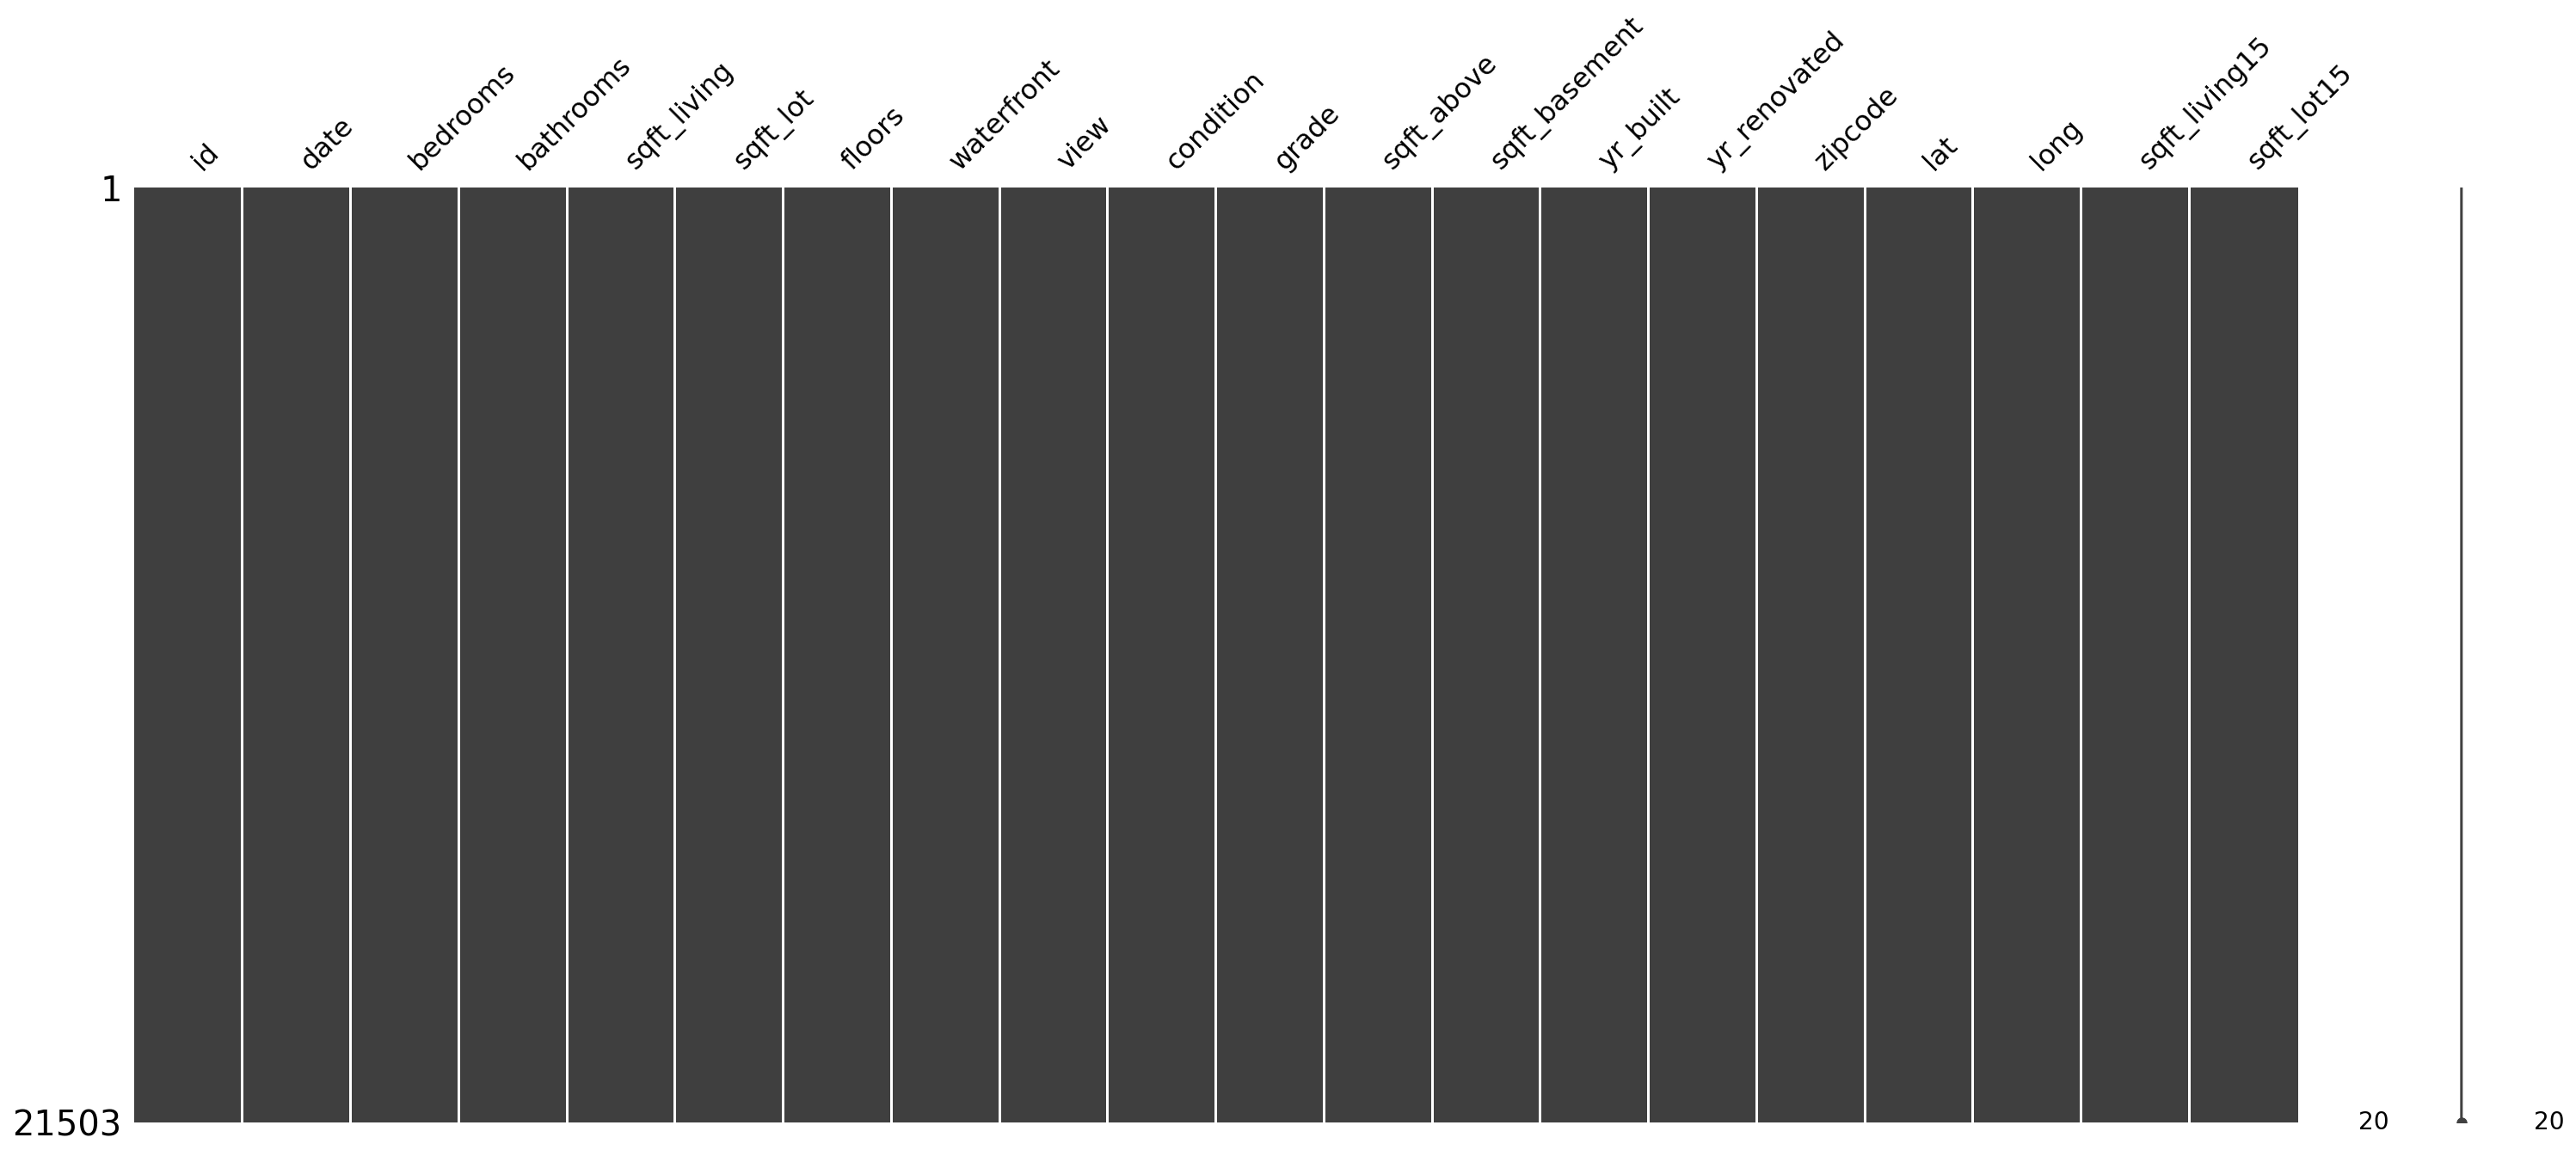

In [113]:
msno.matrix(data)

pandas의 **isnull함수**를 사용해 다시한번 확인한다.

In [114]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


**2. id, date 칼럼 처리**
- id칼럼은 집값을 예측하는데 도움을 주지 않으므로 제거한다.

In [115]:
sub_id = data['id'][train_len:]   # test데이터의 'id'값 모두 가져오기
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- date변수는 연월일시간의 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만든다.

In [116]:
print(data['date'])
data['date'] = data['date'].apply(lambda x : str(x[:6]))    # date칼럼의 값에서 처음 6개 문자(연월일)만 가져온다.

data.head()

0       20141013T000000
1       20150225T000000
2       20150218T000000
3       20140627T000000
4       20150115T000000
             ...       
6463    20140626T000000
6464    20150126T000000
6465    20150219T000000
6466    20140623T000000
6467    20150116T000000
Name: date, Length: 21503, dtype: object


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
전체 데이터들의 분포를 확인합니다.<br>
특히 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업을 합니다.<br><br>
id 컬럼을 제외한 19개 컬럼에 대해 한 번에 모든 그래프를 그려줍니다.<br>
그래프의 종류는 seaborn의 kdeplot을 사용합니다.<br>
**kdeplot**은 '이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수'입니다.

In [ ]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# date 변수(count==0인 경우)는 제외하고 분포를 확인한다.
count = 1
columns = data.columns
print(columns)

for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])     # count번째 칼럼에 있는 데이터에 대한 kde그래프를 그린다.
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보인다. 이렇게 **한 쪽으로 치우친 분포**의 경우에는 **로그 변환(log-scaling)**을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있다.

(의문: 왜 waterfront를 제외하는가? 왜 bedrooms를 포함하는가?)

In [118]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)   # 로그 변환


로그 변환 후의 분포

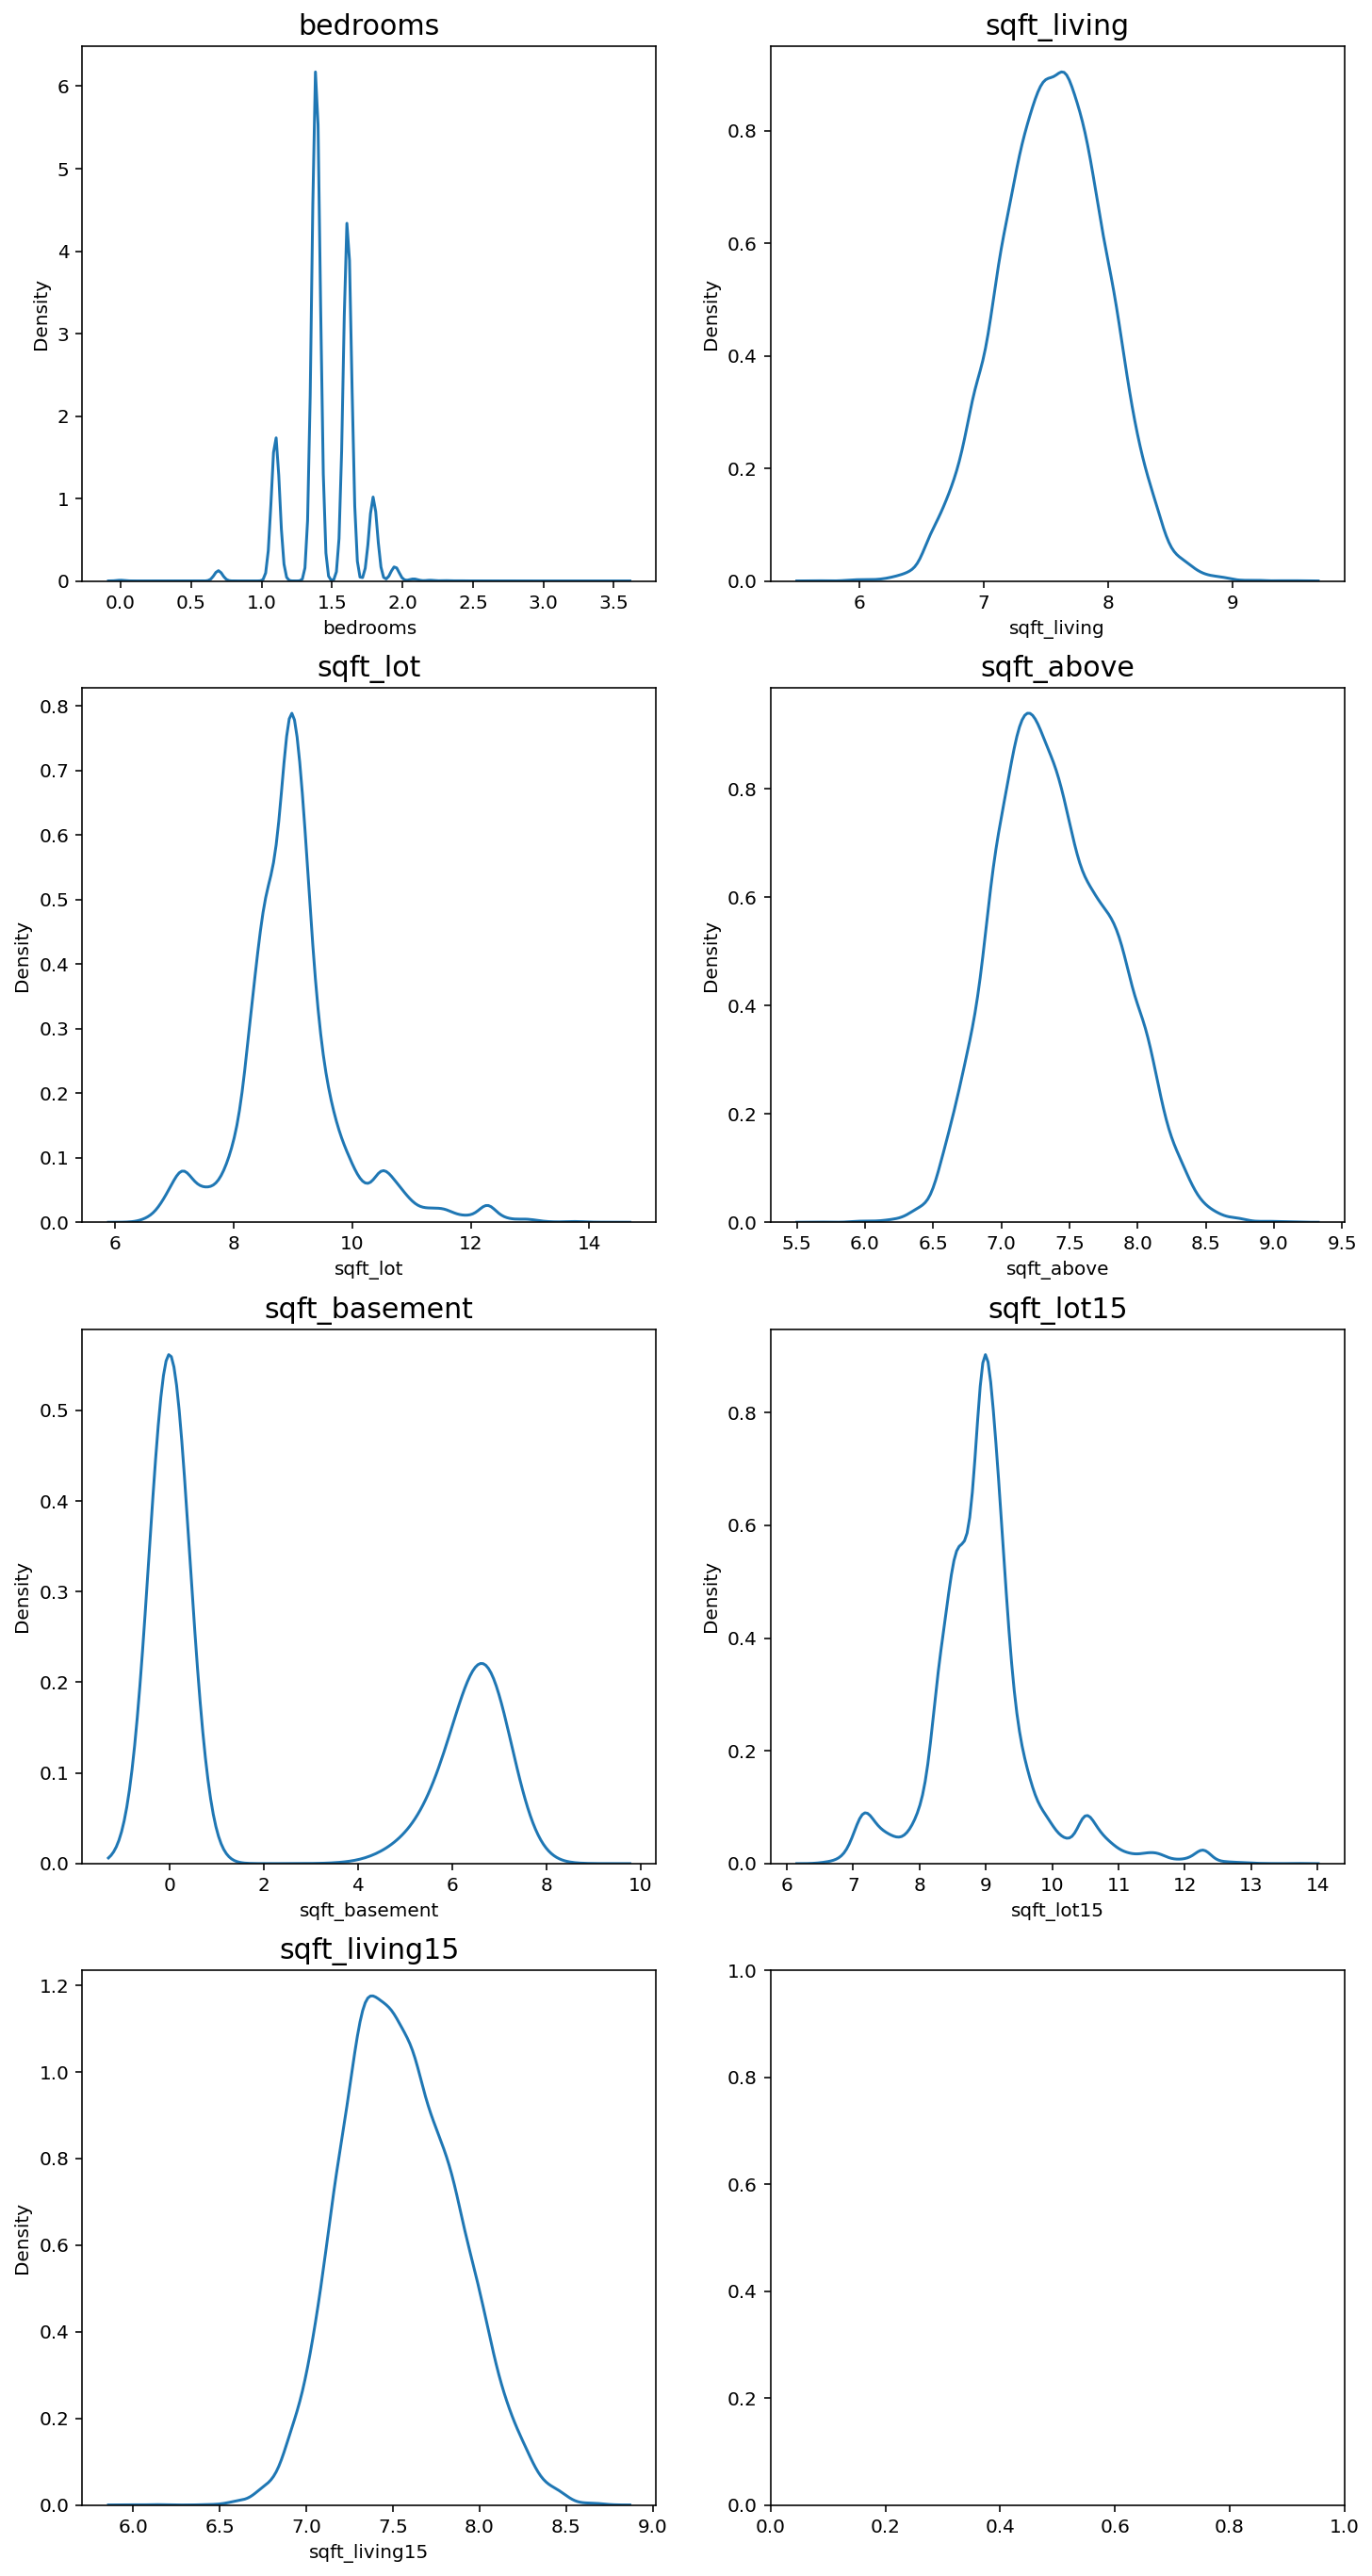

In [119]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### Tip) 왜 로그변환은 분포의 치우침을 줄어들게 만드는 걸까?

로그함수의 특징
- 0<x<1 범위에서는 기울기가 매우 가파릅니다. 즉, xx의 구간은 (0, 1)로 매우 짧은 반면, yy의 구간은 (−∞, 0)으로 매우 큽니다.
- 따라서 0에 가깝게 모여있는 값들이 xx로 입력되면, 그 함수값인 yy 값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.
- 반면, xx값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 이는 곧 큰 xx값들에 대해서는 yy값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 xx를 비교적 작은 yy값의 구간 내에 모이게 하는 특징을 가집니다.

위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있다.

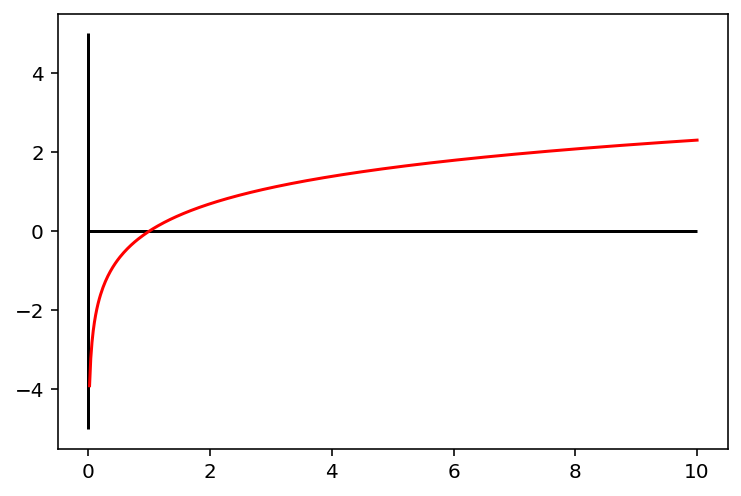

In [120]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)   # 로그함수

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

data['price']데이터를 가지고 있는 y의 kde그래프를 그려보면 0쪽으로 많이 치우쳐있는 것을 확인 할 수 있다.

이 분포에 로그 변환을 취하면, 0 근처에 몰려있는 데이터들은 넓게 퍼지고, 넓게 퍼져있는 소수의 데이터들은 작은 y값으로 모일 것이다.

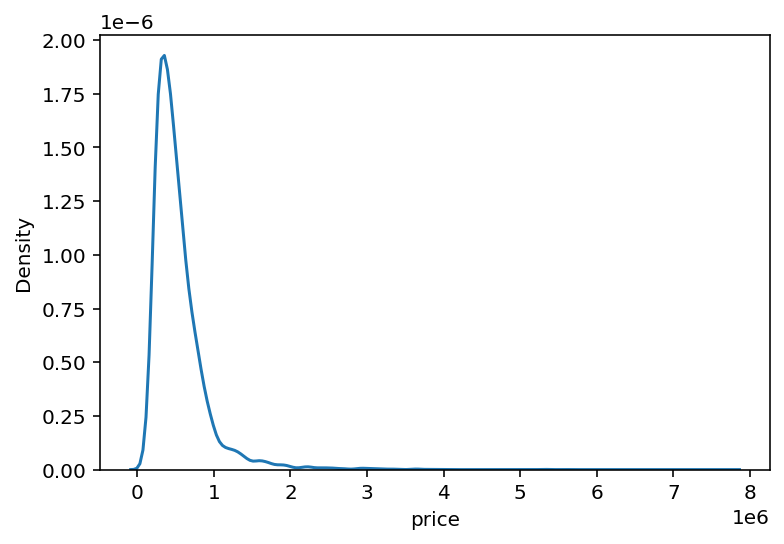

In [121]:
sns.kdeplot(y)
plt.show()

로그변환을 적용 한 data['price']의 분포를 보면 정규분포 모양에 가까워진 것을 확인할 수 있다.

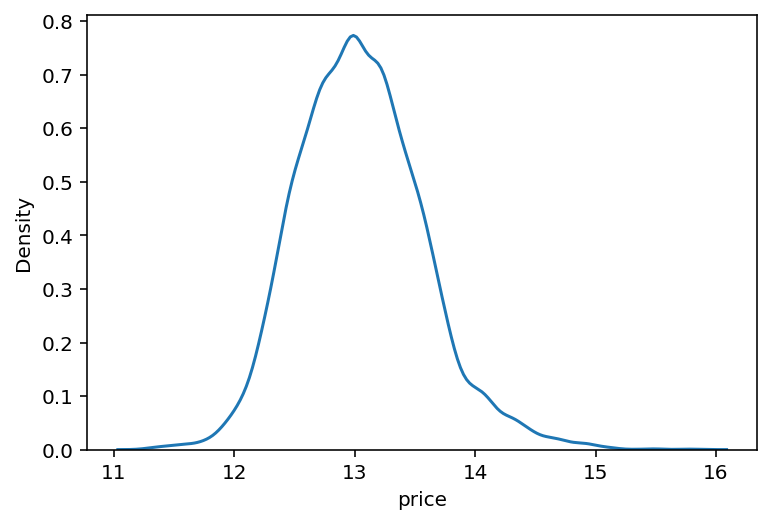

In [122]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

### 학습 데이터와 테스트 데이터를 다시 분리

In [123]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## (4) 모델 설계

 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용할 것이다. = '앙상블' 기법
 > 앙상블(Ensemble) 학습은 여러 개의 학습 알고리즘을 사용하고, 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법입니다. 하나의 강한 머신러닝 알고리즘보다 여러 개의 약한 머신러닝 알고리즘이 낫다는 아이디어로부터 시작되었습니다. <br> <br>
 앙상블은 강력한 개별 모델 하나보다 약한 여러 개의 모델의 결과를 합치는 것이 낫다는 기본 전제로부터 시작됩니다. <br> => [전제가 성립하는 이유](https://gentlej90.tistory.com/73)
 
 [What is Ensemble Learning?](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)

### 1.Average Blending 모델을 만든다
여러 가지 모델의 결과를 **산술평균**하여 블렌딩 모델을 만든다.

모델은 부스팅 계열인 **gboost, xgboost, lightgbm** 세 가지를 사용한다.

In [124]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### 2.Cross Validation(교차 검증)으로 모델의 성능을 평가해보자.
cross_val_score() 함수는 회귀모델을 전달할 경우 $R^2$(결정계수)를 반환한다. $R^2$ 값은 1에 가까울수록 모델이 잘 학습되었다는 것을 나타낸다.<br>
[Coefficient of Determination(결정계수)](https://newsight.tistory.com/259)

<br>

아래 코드의 결과를 통해 3개 트리 모델이 모두 훈련 데이터에 대해 괜찮은 성능을 보여준다는 것을 확인할 수 있다.

In [125]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
[03:23:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어주는 함수 $AveragingBlending$을 작성하여 사용할 것이다.

In [126]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

# 예측값 생성
y_pred = AveragingBlending(models, x, y, sub)

print(len(y_pred))
y_pred

[03:23:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([ 562566.39221578,  389660.68147617, 1340643.45409443, ...,
        438058.69137012,  345498.01852609,  414241.23776683])

제출해야 하는 csv파일의 샘플 'sample_submission.csv'파일을 확인해보자.

In [127]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

print(submission.shape)
submission

(6468, 2)


,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000
...,...,...
6463,21498,100000
6464,21499,100000
6465,21500,100000
6466,21501,100000


위의 결과와 같이 id, price 2개 열로 구성된 DataFrame의 형태로 만들어준다.

In [129]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.625664e+05
1,15036,3.896607e+05
2,15037,1.340643e+06
3,15038,3.317573e+05
4,15039,2.966855e+05


DataFrame으로 저장한 결과를 csv파일로 저장하여 제출한다.

In [130]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/submission.csv


## (5) Kaggle에 첫 결과 제출하기
[대회 링크](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)에서 'Late Submission'으로 csv파일 제출<br>
=> Score가 129439.64507이 나온다.

<br>

대회의 test.csv파일을 사용하면 'Evaluation Exception: Submission must have 6468 rows' 오류가 발생하므로 주의!!!

# 3) 최적의 모델을 찾아보자 (하이퍼파라미터 튜닝)

## (1) 데이터 불러오기 및 전처리 (그대로 진행)

In [140]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


'date'칼럼의 날짜를 연월을 나타내는 int형으로 변환

In [141]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


가격을 예측해야 하므로 y에 정답 레이블을 저장하고, 원본데이터에서는 제거한다.

In [142]:
y = train['price']
del train['price']

print(train.columns)
y

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

추가로 필요없는 'id'칼럼도 제거한다.

In [143]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


test데이터에서도 train데이터와 같은 전처리를 한다.

In [144]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 레이블 데이터 로그변환

레이블 데이터('price'값) 분포확인

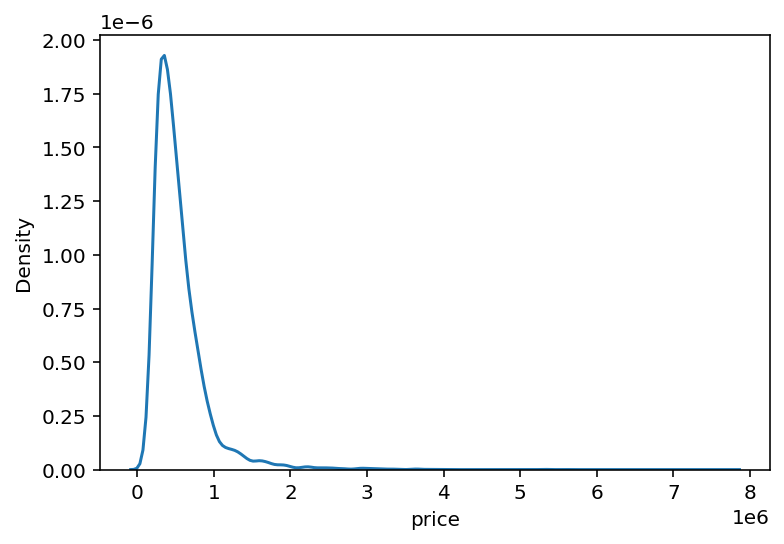

In [145]:
sns.kdeplot(y)
plt.show()

로그변환 적용

In [146]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

로그변환 적용한 레이블 데이터의 분포

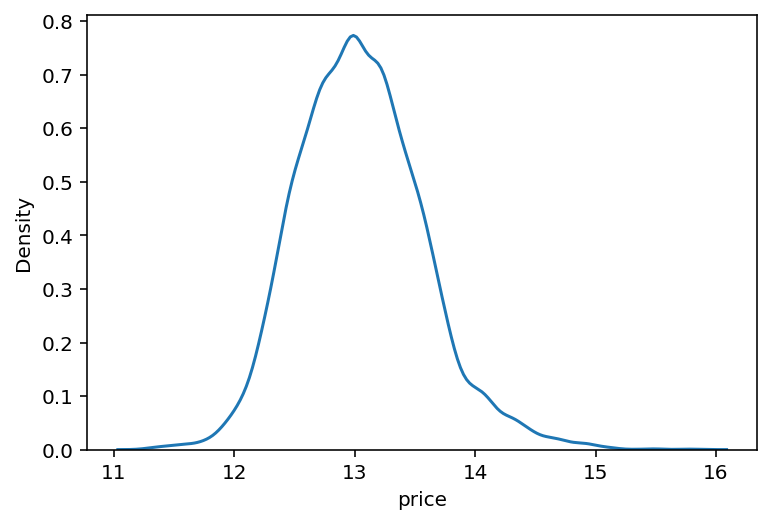

In [147]:
sns.kdeplot(y)
plt.show()

### 학습 데이터의 자료형 확인 
모두 정수 또는 실수형이므로 모델 학습에 활용할 수 있다.

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## (2) 함수로 구현
머신러닝 모델을 학습시키고 튜닝을 하다 보면 몇 시간이 훌쩍 지났는지 모를 만큼 실험해볼 것들이 많습니다.<br>
보다 다양하고 많은 실험을 하기 위해서는, 그만큼 실험을 위한 도구들이 잘 준비되어 있는 것이 유리하겠죠.

따라서 여러 가지 반복되는 작업들은 함수로 먼저 만들어 놓고 많은 실험을 하는 것이 좋습니다. 이제부터 구현해 보겠습니다.

### 1.RMSE 계산
데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위한 **train_test_split**함수와, <br>
RMSE 점수를 계산하기 위한 **mean_squared_error**를 가져옵니다.

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 *np.log1p( )*로 변환이 된 값이기 때문에 **원래 데이터의 단위에 맞게 되돌리기 위해** *np.expm1( )*을 추가해야 한다는 점입니다.

exp로 다시 변환해서 mean_squared_error를 계산한 값에 *np.sqrt( )*를 취하면 RMSE 값을 얻을 수 있겠죠!



In [150]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 2.모델 가져오기

XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델을 가져오겠습니다.

In [151]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

앞으로 우리는 베이스라인에서부터 시작해서 다양한 실험을 통해 **성능이 개선되는지를 검증**해 보려고 합니다. <br>
이때, 어떤 시도가 모델 성능 향상에 긍정적이었는지 여부를 판단하기 위해서는 랜덤적 요소의 변화 때문에 생기는 **불확실성을 제거**해야 합니다. 따라서 아래와 같이 **random_state 값을 특정 값으로 고정**시킬 것입니다.

In [152]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
# random_state=None       # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  (매번 바뀜)
random_state=2020         # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

### Tip) 모델객체의 종류 확인

In [154]:
print(gboost.__class__.__name__)
print(xgboost.__class__.__name__)
print(lightgbm.__class__.__name__)
print(rdforest.__class__.__name__)

GradientBoostingRegressor
XGBRegressor
LGBMRegressor
RandomForestRegressor


### 3.네 가지 모델에 대한 RMSE값 구하기

In [155]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

[05:18:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125576.03932336495,
 'XGBRegressor': 131067.44622809246}

###4.3번 과정을 함수로 구현
모델과 데이터셋이 있다면 RMSE 결과값을 반환하는 함수$get\_scores$를 작성한다.

In [156]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

## (3) 그리드 탐색
하이퍼 파라미터를 조합해 보는 방법으로 **그리드 탐색**과 **랜덤 탐색**이 있다.

<br>

**'그리드 탐색'**은 사람이 먼저 **탐색할 하이퍼 파라미터의 값들을 정해두고,** 그 값들로 만들어질 수 있는 모든 조합을 탐색한다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리하다.

**'랜덤 탐색'**은 사람이 **탐색할 하이퍼 파라미터의 공간만 정해두고,** 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법이다.

$sklearn.model\_selection$ 라이브러리 안에 있는 $GridSearchCV$ 클래스를 활용할 것이다.

<br>

먼저 $GridSearchCV$에 입력되는 인자들은 다음과 같다.

- **param_grid** : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- **scoring** : 모델의 성능을 평가할 지표
- **cv** : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- **verbose** : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- **n_jobs** : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [157]:
from sklearn.model_selection import GridSearchCV

param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어 놓는다.

In [158]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

LightGBM(lgbm) 모델을 사용해보자.

In [159]:
model = LGBMRegressor(random_state=random_state)

 $GridSearchCV$(그리드 탐색)를 이용해서 grid_model **모델을 초기화**하고, train과 y 데이터로 모델을 간단히 **학습**시키면<br>
 param_grid 내의 **모든 하이퍼 파라미터의 조합에 대해 실험이 완료**됩니다.

In [160]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    6.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=2020,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_s

### Q. totalling 20 fits에서 20은 어떻게 계산된 값일까?

- 위에서 우리가 입력한 param_grid에 n_estimators 2 가지, max_depth 2 가지를 넣었으므로 가능한 조합은 총 2 × 2 = 4가지이다.
- 또한, cross validation은 각 경우마다 5번을 진행하니 4 X 5 = 총 20 fits를 진행하게 된다.
- 여기에서 cross validation을 5번 진행하는 이유는, 각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문이다. 한 번만 해 보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확할 것이다.

### 실험에 대한 결과는 모델 객체의 **cv_results_**속성에 저장된다.

In [161]:
grid_model.cv_results_

{'mean_fit_time': array([0.26219773, 0.33619695, 0.83156734, 1.3789001 ]),
 'mean_score_time': array([0.02311482, 0.02844672, 0.05055881, 0.0656219 ]),
 'mean_test_score': array([-0.07339447, -0.05502043, -0.02917734, -0.02702714]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904, -0.05546079, 

cv_results_딕셔너리에서 **'params'는 파라미터 조합**이고, **'mean_test_score'는 각 조합에 대한 테스트 점수**이다.

In [163]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

print(params)
print(score)

[{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
[-0.07339447 -0.05502043 -0.02917734 -0.02702714]


params와 score데이터를 이용하여 하나의 DataFrame으로 만든다.
- score가 음수인 이유는 GridSearchCV에서 모델을 초기화할 때 scoring 인자에 **MSE에 음수를 취한 값**인 **'neg_mean_squared_error'**를 입력했기 때문이다.

<br>

[The scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

- 각 점수(scoring)를 세 가지로 분류해 놓았다. (Classification, Clustering, Regression)
- 어떤 문제를 푸느냐에 따라 각 상황에 알맞은 점수 체계를 사용할 수 있다.

In [164]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


score가 음수로 된 MSE이기 때문에 -1을 곱해주고 np.sqrt로 루트 연산을 해서 RMSE점수로 변환한다.

In [165]:
results['RMSE'] = np.sqrt(-1 * results['score'])

results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


### Q. 위에서 구한 RMSE는 10만을 넘는 값이 었는데 왜 값이 많이 다를까?

위에서 구한 RMSE는 로그변환 된 price값을 다시 복원해서 계산하였는데, 
그리드 탐색을 할 때는 np.expm1()으로 복원하는 과정이 없었기 때문에 log 변환된 price 데이터에서 손실함수값을 계산했기 때문이다.


따라서 위 데이터 프레임에 나타난 score값은 정확히 말하면 RMSE가 아니라 **RMSLE** (Root Mean Squared Log Error) 이다.

In [166]:
results = results.rename(columns={'RMSE': 'RMSLE'})   # 칼럼명 변경

results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


파라미터 조합과 score가 담긴 DataFrame을 **RMSLE가 낮은 순서대로 정렬**한다.
- DataFrame의 sort_values메소드 사용

In [167]:
results = results.sort_values('RMSLE')

results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


### 지금까지의 그리드 탐색 과정을 함수로 작성
- 파라미터 조합과 score, RMSLE가 담긴 DataFrame을 반환한다.

In [168]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

## (4) 실험 결과 제출

### 1.최적의 하이퍼파라미터 조합 찾기 (그리드 탐색)

In [169]:
# 하이퍼파라미터 값 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

# 모델 초기화
model = LGBMRegressor(random_state=random_state)

# 직접 작성한 '그리드 탐색' 함수
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    5.8s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


### 2.최적의 하이퍼파라미터로 모델 학습

위 실험을 통해 가장 좋은 조합은 max_depth=10, n_estimators=100 이라는 걸 확인했다.

해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출하면 된다.

In [170]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)

model.fit(train, y)

prediction = model.predict(test)

prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

예측결과에 np.expm1( )를 씌워서 원래 스케일로 되돌려야 한다. <br>
=> RMSLE를 RMSE로 변환.

In [171]:
prediction = np.expm1(prediction)

prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

### 3.예측결과를 csv파일로 저장

In [172]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [173]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')    # 저장할 파일명
submission.to_csv(submission_csv_path, index=False)    # csv파일로 저장

print(submission_csv_path)

/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/submission_lgbm_RMSLE_0.164399.csv


### 4.위 과정(모델 학습~csv파일저장)을 함수로 구현

In [175]:
"""
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

작성한 함수를 사용해서 한 번에 csv파일로 저장해보자.

In [176]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/submission_lgbm_RMSLE_0.0168.csv saved!
